I want to compare the results of Kraskov MI and the neural estimation one, using different values of k for Kraskov. Specifically, if the actual value of MI is very small, you are not able to estimate it using Kraskov with large k. If you decrease k, you are able to estimate it.

In [197]:
import pandas as pd
import numpy as np
from minepy import MINE
import minepy
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_selection import mutual_info_regression
from neural_estimation import MINE

In [6]:
import warnings; warnings.simplefilter('ignore')

## Import data
I will just use the columns from 318 to the end

In [2]:
data = pd.read_csv("WHO.csv")

# Exclude the first two columns, that are just the name of the country and the ID

data = data.iloc[:,2:]  

reduced_data = data.iloc[:,318:]

## Kraskov MI

In [3]:
from pairwise_dependences import pairwise_kraskov_MI, pairwise_corr

In [18]:
%%time 
pearson_corr = pairwise_corr(reduced_data)

CPU times: user 2.62 ms, sys: 795 µs, total: 3.42 ms
Wall time: 2.48 ms


In [19]:
%%time
kraskov_MI = pairwise_kraskov_MI(reduced_data, n_neighbors=1)

CPU times: user 1.96 s, sys: 2.95 ms, total: 1.96 s
Wall time: 1.96 s


In [9]:
print(sum(kraskov_MI<0), sum(kraskov_MI==-1), sum(kraskov_MI==-2))

37 0 37


In [10]:
valid_indices = kraskov_MI >= 0
print(sum(valid_indices==True))

666


In [20]:
pearson_corr = pearson_corr[valid_indices]
kraskov_MI = kraskov_MI[valid_indices]

## Neural MI

In [11]:
%%time
#neural_MI = pairwise_neural_estimation_MI(reduced_data, n_epoch=400)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs


In [31]:
#np.save("results/neural_MI_WHO_from_col318_toend", neural_MI)

In [8]:
neural_MI = np.load("results/neural_MI_WHO_from_col318_toend.npy")

In [12]:
neural_MI = neural_MI[valid_indices]

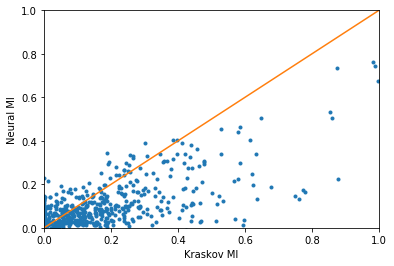

In [21]:
plt.plot(kraskov_MI, neural_MI[:, 0], ".")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("Kraskov MI")
plt.ylabel("Neural MI")
plt.plot(np.linspace(0,1), np.linspace(0,1))

Neural estimation tends to be smaller than kraskov one

Text(0.5,0,'Neural MI')

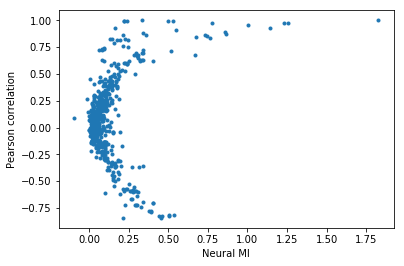

In [34]:
plt.plot(neural_MI[:, 0], pearson_corr, ".")
plt.ylabel("Pearson correlation")
plt.xlabel("Neural MI")

# Smoother implementation

In [32]:
n_neighbors = 1

In [33]:
%%time 
pearson_corr = pairwise_corr(reduced_data)

CPU times: user 1.56 ms, sys: 2.8 ms, total: 4.36 ms
Wall time: 2.99 ms


In [34]:
%%time
kraskov_MI = pairwise_kraskov_MI(reduced_data, n_neighbors=n_neighbors)

CPU times: user 1.98 s, sys: 0 ns, total: 1.98 s
Wall time: 1.98 s


In [35]:
neural_MI = np.load("results/neural_MI_WHO_from_col318_toend.npy")

In [36]:
print(sum(kraskov_MI<0), sum(kraskov_MI==-1), sum(kraskov_MI==-2))

37 0 37


In [37]:
valid_indices = kraskov_MI >= 0
print(sum(valid_indices==True))

666


In [38]:
pearson_corr = pearson_corr[valid_indices]
kraskov_MI = kraskov_MI[valid_indices]
neural_MI = neural_MI[valid_indices]

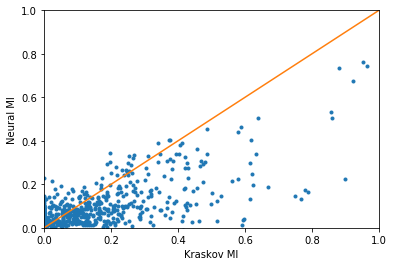

In [39]:
plt.plot(kraskov_MI, neural_MI[:, 0], ".")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("Kraskov MI")
plt.ylabel("Neural MI")
plt.plot(np.linspace(0,1), np.linspace(0,1))
plt.show()

In [59]:
def compare_kraskov_neural(n_neighbors):
    kraskov_MI = pairwise_kraskov_MI(reduced_data, n_neighbors=n_neighbors)
    neural_MI = np.load("results/neural_MI_WHO_from_col318_toend.npy")
    valid_indices = kraskov_MI >= 0
    kraskov_MI = kraskov_MI[valid_indices]
    neural_MI = neural_MI[valid_indices]
    
    return kraskov_MI, neural_MI

def scatter_plots(kraskov_MI, neural_MI):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(kraskov_MI, neural_MI[:, 0], s=2)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.0])
    ax.set_xlabel("Kraskov MI")
    ax.set_ylabel("Neural MI")
    ax.plot(np.linspace(0,1), np.linspace(0,1), color="orange")
    
    return fig, ax
    

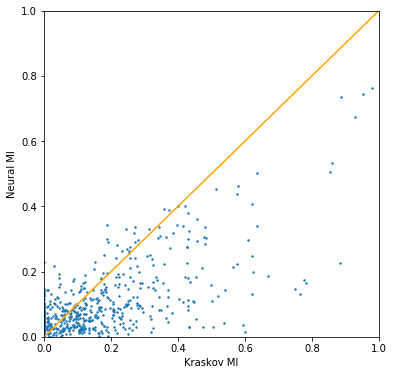

In [60]:
kraskov_MI1, neural_MI1 = compare_kraskov_neural(1)

fig1, ax1 = scatter_plots(kraskov_MI1, neural_MI1)

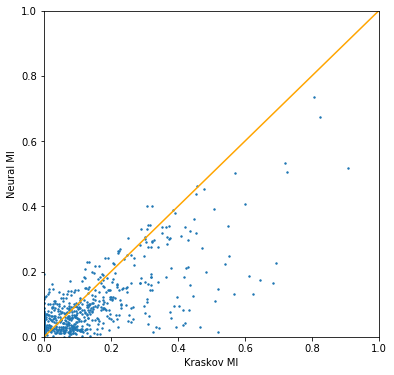

In [61]:
kraskov_MI2, neural_MI2 = compare_kraskov_neural(2)
fig2, ax2 = scatter_plots(kraskov_MI2, neural_MI2)

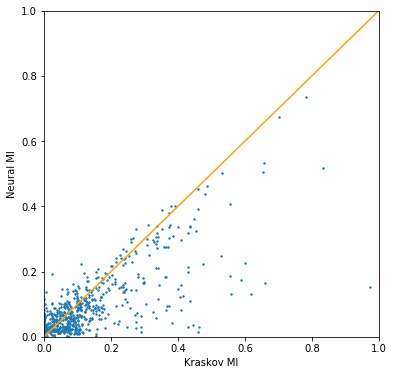

In [62]:
kraskov_MI3, neural_MI3 = compare_kraskov_neural(3)
fig3, ax3 = scatter_plots(kraskov_MI3, neural_MI3)

# Try now with a bivariate Gaussian, for which the mutual information is known:

$ I(x;y) = - { 1 \over 2 } \ln (1 - \rho^2) $


In [214]:
def bivariate_gaussian(rho, size):
    mean = [0,0]
    cov_matrix = [[1, rho], [rho, 1]]
    res = np.random.multivariate_normal(mean, cov_matrix, size)
    x, y = res[:, 0], res[:, 1]
    return x.reshape(-1, 1), y.reshape(-1, 1)

def MI_bivariate_gaussian(rho):
    return -0.5*np.log(1-rho**2)

In [188]:
rho = 0.5

In [218]:
x, y = bivariate_gaussian(rho, 1000)

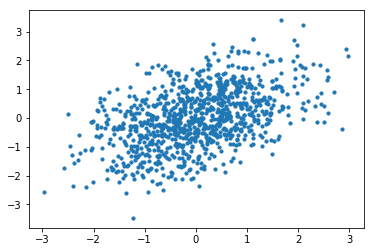

In [206]:
plt.scatter(x, y, s=10)

In [228]:
MI_bivariate_gaussian(rho)

0.14384103622589045

Comparison of the results for different values of k

In [312]:
k_values = [1,2,3,4,5]
rho_values = np.linspace(0, 1, 100)
MI_kraskov = np.zeros((len(k_values), len(rho_values)))

In [313]:
for i, k in enumerate(k_values):
    for j, rho in enumerate(rho_values):
        x, y = bivariate_gaussian(rho, 100)
        MI_kraskov[i, j] = mutual_info_regression(x, y, n_neighbors=k)

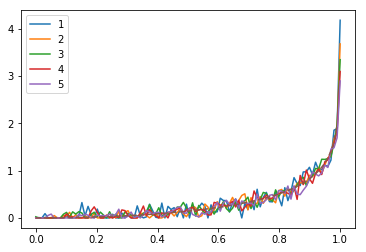

In [314]:
for i in range(len(k_values)):
    plt.plot(rho_values, MI_kraskov[i], label=str(k_values[i]))

plt.plot(rho_values, MI_bivariate_gaussian(rho_values), "--")
plt.legend()

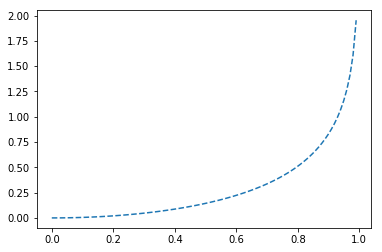

In [315]:
plt.plot(rho_values, MI_bivariate_gaussian(rho_values), "--")

In [316]:
k_values = np.arange(1, 11)
rho_values = np.linspace(0, 1, 5)[0:-1]
MI_kraskov_2 = np.zeros((len(k_values), len(rho_values)))

In [317]:
for i, k in enumerate(k_values):
    for j, rho in enumerate(rho_values):
        x, y = bivariate_gaussian(rho, 100)
        MI_kraskov_2[i, j] = mutual_info_regression(x, y, n_neighbors=k)

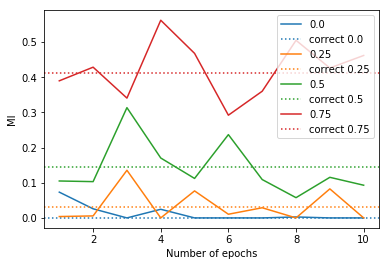

In [318]:
for i in range(len(rho_values)):
    im = plt.plot(k_values, MI_kraskov_2[:,i], label=str(rho_values[i]))
    plt.axhline(MI_bivariate_gaussian(rho_values[i]), label = "correct "+str(rho_values[i]), ls='dotted', color=im[0].get_color())

plt.xlabel("Number of epochs")
plt.ylabel("MI")    
plt.legend()

In [ ]:
for i in range(len(k_values)):
    plt.plot(rho_values, MI_kraskov[i], label=str(k_values[i]))

plt.plot(rho_values, MI_bivariate_gaussian(rho_values), "--")
plt.legend()

### Compare MINE results with the standard one, for different number of epochs.

In [230]:
MINE(x, y)

(0.14196205765008926, 3.231117268036974e-05)

In [290]:
epochs_values = [200, 400, 600, 800, 1000]
rho_values = np.linspace(0, 1, 5)[0:-1] # exlude rho=1 because you get infinite MI
MI_neural = np.zeros((len(epochs_values), len(rho_values), 2))

In [291]:
for i, epoch in enumerate(epochs_values):
    for j, rho in enumerate(rho_values):
        x, y = bivariate_gaussian(rho, 100)
        MI_neural[i, j] = MINE(x, y, n_epoch=epoch)

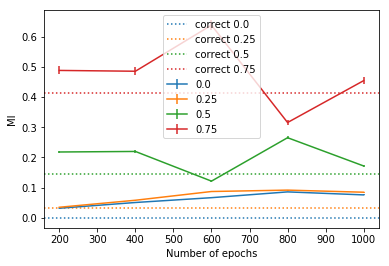

In [319]:
for i in range(len(rho_values)):
    im = plt.errorbar(epochs_values, MI_neural[:,i,0], yerr=MI_neural[:,i,1] , label=str(rho_values[i]))
    plt.axhline(MI_bivariate_gaussian(rho_values[i]), label = "correct "+str(rho_values[i]), ls='dotted', color=im[0].get_color())

plt.xlabel("Number of epochs")
plt.ylabel("MI")    
plt.legend()